# Explore pancreas.plasma.ev.long.RNA.normalized.deseq.biotype.counts.csv

- [https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE133684)
- /extraCellularRNA/R/notebooks/pancreas.plasma.ev.long.RNA.DESeq.normalize.Rmd
- aedavids@ucsce
- 10/15/2020

In [1]:
from   bme263DataVis.utilities import MatPlotLibUtilities
from   bme263DataVis.plotCumulativeProbablty import PlotCumulativeProbablity
from   bme263DataVis.plotProbMassFunc import PlotProbMass

# https://songhuiming.github.io/pages/2017/04/02/jupyter-and-pandas-display/
# display(HTML(' <span style="color:red">the title is: <h1>Hello, world!</h1> </span>  '))
# display(HTML(df.to_html()))
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pathlib as pl

mplu = MatPlotLibUtilities()
mplu.loadStyle()

# macbookpro = "../data/R/output"
# courtyard = "../R/output"
# biodataRootDir = courtyard
biodataRootDir = "../data/R/output"

## load data

In [2]:
bioTypeCountFiles = {
                    "A549_0.2MOI_24hr":"A549_0.2MOI_24hr.normalized.deseq.BIO_TYPE.counts.csv"
                    ,"bioIvt":"bioIvt.normalized.deseq.BIO_TYPE.counts.csv"
                    ,"panc1_intra":"panc1_intra.normalized.deseq.BIO_TYPE.counts.csv"
                    ,"pittsburgh_ctrl":"pittsburgh_ctrl.normalized.deseq.BIO_TYPE.counts.csv"
                    }

In [3]:
outDir = "../data/normalized.deseq.biotype.out"
imgOutDir = pl.Path(outDir).joinpath("img")  

imgOutDir.mkdir(parents=True, exist_ok=True)

In [4]:
def renameCol(df):
    colNamesList = df.columns.to_list()
    colNamesList[0] = "biotype"
    df.columns = colNamesList  
    df.set_index('biotype', inplace=True)

def getConditions(df):
    # ignore biotype
    cNames = df.columns[1:]
    # format for column names "condition_sampleId"
    # condition is not a great name, value might be treatement, or disease
    # example Mock_SRR11412240  Mock_SRR11412241  Mock_SRR11412242
    conditions = [ cs.split("_")[0] for cs in cNames ]
    # get unique conditions
    conditions = list(set(conditions))
    return conditions

def selectDiseaseStateSamples(df, conditionState):
    '''
    arguments:
        example "Mock", 'healthy', 'PDAC', ...
        
    returns 
        pandas data frame
    '''
    selectedColNames = [c for c in df.columns if c.startswith(conditionState)]
    retDF = df.loc[:, selectedColNames]
    return retDF

In [5]:
dataSetDict = dict()
for key,filePath in bioTypeCountFiles.items() :
    filePath = pl.Path(biodataRootDir, filePath)
    print(filePath)
    df = pd.read_csv(filePath)
    renameCol(df)
    
    # split 
    conditions = getConditions(df)
    print("conditions: {}".format(conditions))
    for condition in conditions:
        conditionDF = selectDiseaseStateSamples(df, condition)
        conditionKey = "{}_{}".format(key, condition)
        dataSetDict[conditionKey] = conditionDF


../data/R/output/A549_0.2MOI_24hr.normalized.deseq.BIO_TYPE.counts.csv
conditions: ['Mock', 'SARS']
../data/R/output/bioIvt.normalized.deseq.BIO_TYPE.counts.csv
conditions: ['panc', 'covid']
../data/R/output/panc1_intra.normalized.deseq.BIO_TYPE.counts.csv
conditions: ['ctrl', 'kras']
../data/R/output/pittsburgh_ctrl.normalized.deseq.BIO_TYPE.counts.csv
conditions: ['ctrl']


## Convert to probablities and explore cumlative distribution function

In [6]:
def convertCountsToProb(countDF):
    '''
    adds psudo count
    
    Kullback–Leibler divergence will be inf if any of the predicted probablities are zero
    '''
    tmpDF = countDF + 1
    colSums = tmpDF.sum()
    ret = tmpDF / colSums
    return ret

In [7]:
probDistDict = dict()
for key, df in dataSetDict.items():
    colAxis = 1
    colSumSeries = df.sum(axis=colAxis)
    probablityDistribution = convertCountsToProb(colSumSeries)
    # sanity check. each column must sum to 1.0
    assert np.isclose( probablityDistribution.sum(), 1.0 ), "ERROR key:{}".format(key)
    probDistDict[ key ] = probablityDistribution

In [8]:
probDistDict.keys()

dict_keys(['A549_0.2MOI_24hr_Mock', 'A549_0.2MOI_24hr_SARS', 'bioIvt_panc', 'bioIvt_covid', 'panc1_intra_ctrl', 'panc1_intra_kras', 'pittsburgh_ctrl_ctrl'])

## find missing biotypes
There are some missing biotypes however they are probably not signifigant becuase their probaliby masss is almost zero

## Plot

In [9]:
def findUniqBiotypes(seriesDict) :
    '''
    dictionary of pandas series
    
    assume series are indexed by biotype
    
    returns set of biotype
    '''
    allIndex = list()
    for key in seriesDict.keys():
        s = seriesDict[key]
        allIndex.extend( s.index.to_list()  )  
        
    # find unique entries
    ret = set(allIndex)
    
    return ret

In [10]:
def balanceBiotypes(seriesDict):
    '''
    add missing bio types
    returns a pandas data frame where colums in series Dict
    '''
    retDF = None
    
    biotypeSet = findUniqBiotypes( seriesDict )
    for key,series in seriesDict.items():
        
        #colNamesList.append( key )
        seriesBioTypeSet = set(series.index)

        # find types that are missing from dfBioTypeSet
        addBiotypeSet = biotypeSet - seriesBioTypeSet
        
        for biotype in addBiotypeSet:
            series.loc[biotype] = 0.0
        
        df = pd.DataFrame({key:series} )

        if retDF is not None:
            colAxis = 1
            retDF = pd.concat( [retDF, df], axis=colAxis)  
        else :
            retDF = df
            
    retDF.index.name = "biotype"
    return retDF
        
    
# testSeriesDict = {
#     'A549_0.2MOI_24hr_Mock': probDistDict['A549_0.2MOI_24hr_Mock'] # 23
#     ,'A549_0.2MOI_24hr_SARS':probDistDict['A549_0.2MOI_24hr_SARS'] # 24
# }
# testDF = balanceBiotypes(testSeriesDict)

biotypeDF = balanceBiotypes(probDistDict)
print(biotypeDF.shape)
print(biotypeDF.dtypes)

(30, 7)
A549_0.2MOI_24hr_Mock    float64
A549_0.2MOI_24hr_SARS    float64
bioIvt_panc              float64
bioIvt_covid             float64
panc1_intra_ctrl         float64
panc1_intra_kras         float64
pittsburgh_ctrl_ctrl     float64
dtype: object


../data/normalized.deseq.biotype.out/img/normalized_biotype_distibutions.png


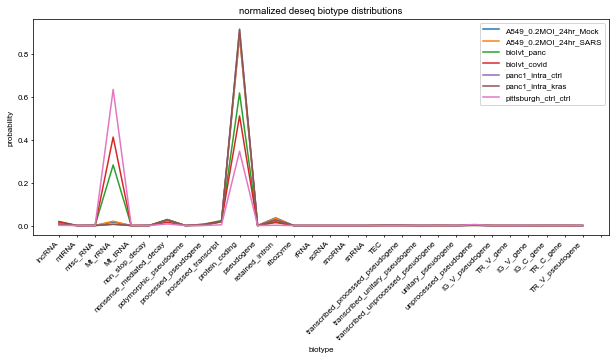

In [11]:
# create panel
figureWidthInInches = 8
figureHeightInInches = 3
fig = plt.figure(figsize=(figureWidthInInches,figureHeightInInches))
panel = mplu.createPanelSameSizeAsFig(fig)

title = "normalized deseq biotype distributions"
PlotProbMass(panel, biotypeDF, title=title)

outfile = imgOutDir.joinpath("normalized_biotype_distibutions.png")
print(outfile)
# if you do not set bbox_inches saved img will be clipped
fig.savefig(outfile, bbox_inches='tight') #BME163 style sheet should set dpi=600